In [1]:
import sys
sys.path.append("../") 

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from utils.environment.CIgame import GraphGame
from open_spiel.python.algorithms import random_agent
from tqdm import tqdm
from igraph import Graph
import json

#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel
from utils.validation import get_Validation, area_under_curve
from utils.reinforcement_learning.CIGraphNN import CIGraphNN
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def CV_evaluation(graph_path, model_path,filename, parameter_path):  
    params = Params(parameter_path)
    _NUM_PLAYERS = 2
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    for iteration in np.arange(start,end,interval):
        name = model_path+str(iteration)
        loading_attacker = torch.load(name)
        auc_individual = []
        for file in filename:
            GRAPH,_ = input_graph(graph_path,file)
            N = GRAPH.vcount()
            game = "graph_attack_defend"
            env = Environment(game)
            num_actions = env.action_spec()["num_actions"]
            attacker = DQN(player_id=0,
                            state_representation_size=params.centrality_features,
                            hidden_layers_sizes= params.hidden_layers,
                           global_feature_size =params.global_features,
                           num_actions=num_actions)
            attacker._q_network.load_state_dict(loading_attacker["_q_network"])
            attacker._optimizer.load_state_dict(loading_attacker["_optimizer"])
            agents = [attacker,attacker]
            rewards, lcc, actions = EvaluateModel(env,agents,GRAPH)
            #Compute Area under the curve
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC
def get_cv(feature,result):
    model_path = "../model/CI_BA_Graph_Feature_"+feature+"/model_BAGraph_"
    parameters = "../utils/hyperparameters/params_Feature_"+feature+".json"
    value = {}
    graph_path ="../Dataset/SyntheticGraph/"
    filename = ['barabasi_albert_' + str(i) for i in [30,50]]
    x, ba = CV_evaluation(graph_path,model_path,filename,parameters)
    value['ba'] = ba
    filename = ['erdos_renyi_' + str(i) for i in  [30,50]]
    x,er = CV_evaluation(graph_path,model_path,filename,parameters)
    value['er'] = er
    filename = ['small-world_' + str(i) for i in  [30,50]]
    x,sw = CV_evaluation(graph_path,model_path,filename,parameters)
    value['x'] = x
    value['sw'] = sw
    result[feature] = value
    with open("result.json", "w") as outfile:
        json.dump(result, outfile, cls=NpEncoder)

# Evaluation With Feature: Reduced Degree

In [16]:
# Opening JSON file
with open('result.json') as json_file:
    result = json.load(json_file)
get_cv("ReducedDegree",result)

# Evaluation With Feature: Eigen

In [2]:
# Opening JSON file
with open('result.json') as json_file:
    result = json.load(json_file)
get_cv("Eigen",result)

# Evaluation With Feature: PowerRank

In [3]:
# Opening JSON file
with open('result.json') as json_file:
    result = json.load(json_file)
get_cv("PageRank",result)

# Evaluation With Feature: CI

In [2]:
# Opening JSON file
with open('result.json') as json_file:
    result = json.load(json_file)
get_cv("CI",result)

# Evaluation With Feature: All

In [2]:
# Opening JSON file
with open('result.json') as json_file:
    result = json.load(json_file)
get_cv("All",result)

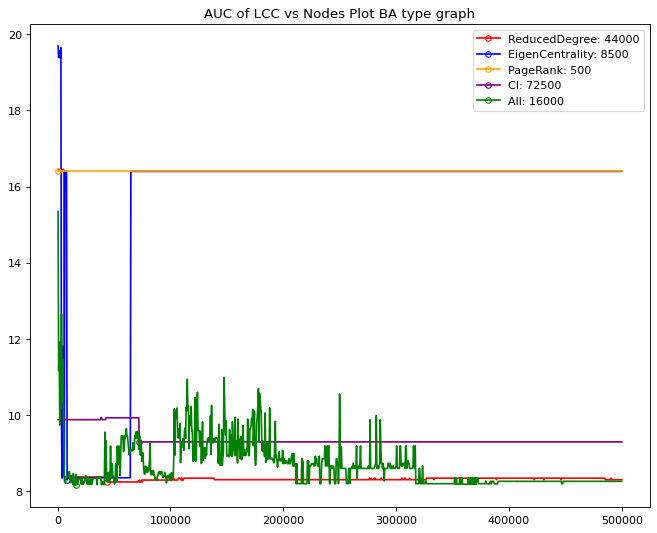

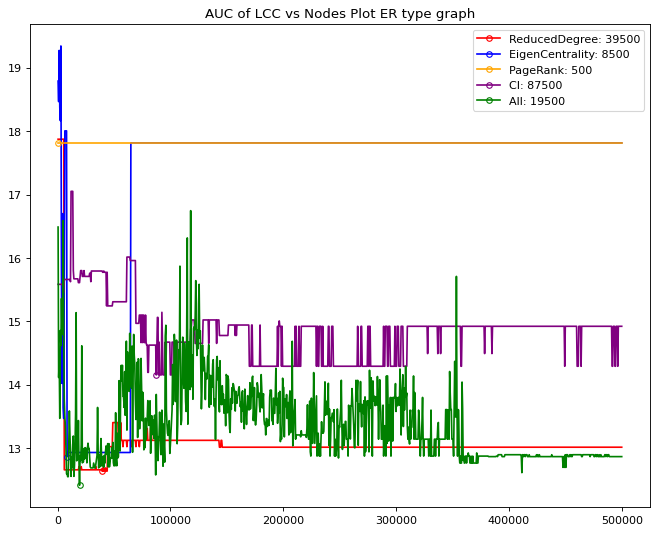

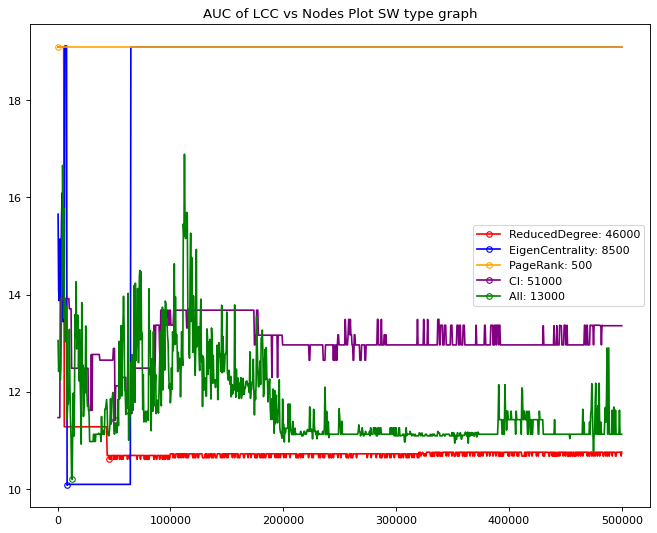

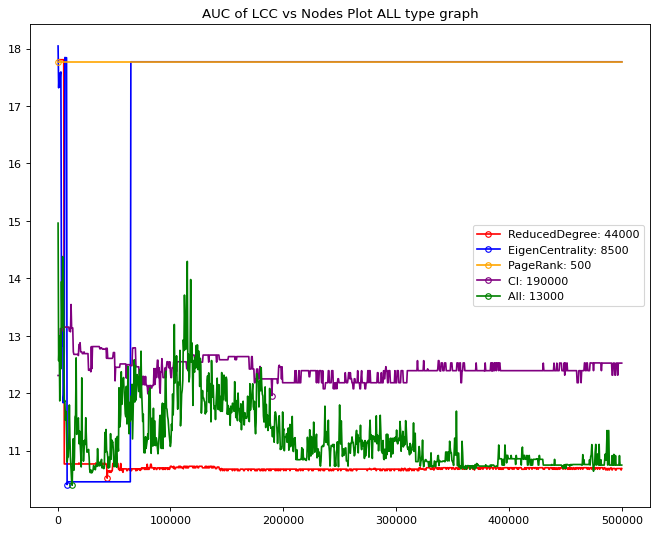

In [24]:
def get_value(result,evaluation):
    plt.figure(figsize=(10, 8), dpi=80)
    for feature in result:
        x = result[feature]["x"]
        if feature == "ReducedDegree":
           color = 'red'
           label = 'ReducedDegree'
           inv = 'red'
        elif feature == "Eigen":
            color = 'blue'
            label = 'EigenCentrality'
            inv = 'blue'
        elif feature == "PageRank":
            color = 'orange'
            label = 'PageRank'
            inv = 'orange'
        elif feature == "CI":
            color = 'purple'
            label = 'CI'
            inv = 'purple'
        else:
            color = 'green'
            label = 'All'
            inv = 'green'
        if evaluation == "all":
            auc = np.mean([result[feature]['ba'],result[feature]['er'],result[feature]['sw']],axis=0)
        else:        
            auc = result[feature][evaluation]
        min_value = np.argmin(auc)
        min_vc = x[min_value]
        plt.plot(x,auc, color = color)
        plt.plot(min_vc, auc[min_value], marker="o", color = color,markersize=5, markeredgecolor=color, markerfacecolor="None",label= label+": "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+evaluation.upper()+" type graph")
    plt.legend()
    plt.savefig("Eval_"+evaluation)
    plt.show()
            
with open('result.json') as json_file:
    result = json.load(json_file)
get_value(result,"ba")
get_value(result,"er")
get_value(result,"sw")
get_value(result,"all")